In [1]:
# Much of this comes from the site https://www.ethanrosenthal.com/2017/06/20/matrix-factorization-in-pytorch/
# Accessed on March 7th, 2021

import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
import torch
import os

from pathlib import Path

In [2]:
#%%
# If using colab
# from google.colab import drive
# drive.mount('/content/drive')
# DRIVE_PATH = "/content/drive/Shared drives/CMPUT466 Project"

# If using windows

DRIVE_PATH = Path("G:/Shared drives/CMPUT466 Project")
DATA_FOLDER=DRIVE_PATH/"src/data/"
train = pd.read_csv(DATA_FOLDER/"user_data_train.csv")
validation = pd.read_csv(DATA_FOLDER/"user_data_validation.csv")
test = pd.read_csv(DATA_FOLDER/"user_data_test.csv")
data = pd.concat([train, validation, test])

In [3]:
def to_categorical(df, col):
    keys = df[col].unique()
    d = {key: i for i, key in enumerate(keys)}
    return np.array([d[key] for key in df[col]])

def get_sparse_matrix(df, usr_col, item_col, rating_col):
    return df.groupby([usr_col, item_col])[rating_col].max().unstack().fillna(0).astype(int)

def sparse_train_val_test_split(df, val_percent, test_percent):
    pos = np.transpose(df.nonzero())
    neg = np.transpose((~df.astype(bool)).nonzero())

    pos = np.random.permutation(pos)
    neg = np.random.permutation(neg)
    train_pos, val_pos, test_pos = np.vsplit(pos, [
        int(pos.shape[0] * (1 - (val_percent + test_percent))),
        int(pos.shape[0] * (1 - val_percent))
    ])
    train_neg, val_neg, test_neg = np.vsplit(neg, [
        int(neg.shape[0] * (1 - (val_percent + test_percent))),
        int(neg.shape[0] * (1 - val_percent))
    ])
    train = np.append(train_pos, train_neg, axis=0)
    validate = np.append(val_pos, val_neg, axis=0)
    test = np.append(test_pos, test_neg, axis=0)
    return train, validate, test

data["Username"] = to_categorical(data, "Username")
data["Title"] = to_categorical(data, "Title")

ratings = get_sparse_matrix(data, "Username", "Title", "Userscore").to_numpy()
train_idxs, validate_idxs, test_idxs = sparse_train_val_test_split(ratings, 0.1, 0.1)

(139875, 2) (17484, 2) (17485, 2)


In [4]:
""" https://arxiv.org/pdf/1812.01478v1.pdf """

class DMF(nn.Module):
    def __init__(self, n_users, n_items, n_factors=64):
        super().__init__() 
        self.user_fc1 = nn.Linear(n_items, 1024).cuda() # The array of users will be (BATCH_SIZE x n_items)
        self.user_fc2 = nn.Linear(1024, 512).cuda()
        self.user_fc3 = nn.Linear(512, n_factors).cuda()
        self.item_fc1 = nn.Linear(n_users, 1024).cuda() # The array of items will be (BATCH_SIZE x n_users)
        self.item_fc2 = nn.Linear(1024, 512).cuda()
        self.item_fc3 = nn.Linear(512, n_factors).cuda()
        
        self.sim = nn.CosineSimilarity()
                
    def forward(self, users, items):
        # Users network
        users = F.relu(self.user_fc1(users))
        users = F.relu(self.user_fc2(users))
        users = self.user_fc3(users)
        
        # Items network
        items = F.relu(self.item_fc1(items))
        items = F.relu(self.item_fc2(items))
        items = self.item_fc3(items)

        # Simulate pair-wise cosine similarity
        res = self.sim(users, items)
#         return torch.add(torch.mul(res, 0.5-1e-6), 0.5) # Map from [-1, 1] to [eps, 1-eps]
        return torch.add(torch.mul(res, 5), 5)
        
def get_pos_neg_samples(data, idxs, neg_ratio):
    pos = data[idxs[:,0], idxs[:,1]].nonzero()[0]
    neg = (~data[idxs[:,0], idxs[:,1]].astype(bool)).nonzero()[0]
    base = len(pos)
    p = np.random.choice(len(neg), base*neg_ratio)
    return np.append(idxs[pos], idxs[p], axis=0)
        
def NCE_Loss(outputs, targets):
    max_rating = 10
    targets = torch.div(targets, max_rating)
    
    pos = torch.mul(targets, torch.log(outputs))
    neg = torch.mul(1 - targets, torch.log(1 - outputs))
    return -torch.sum(torch.add(pos, neg))
    
model = DMF(*ratings.shape)

100%|██████████| 3279/3279 [02:46<00:00, 19.68it/s]


<IPython.core.display.Javascript object>


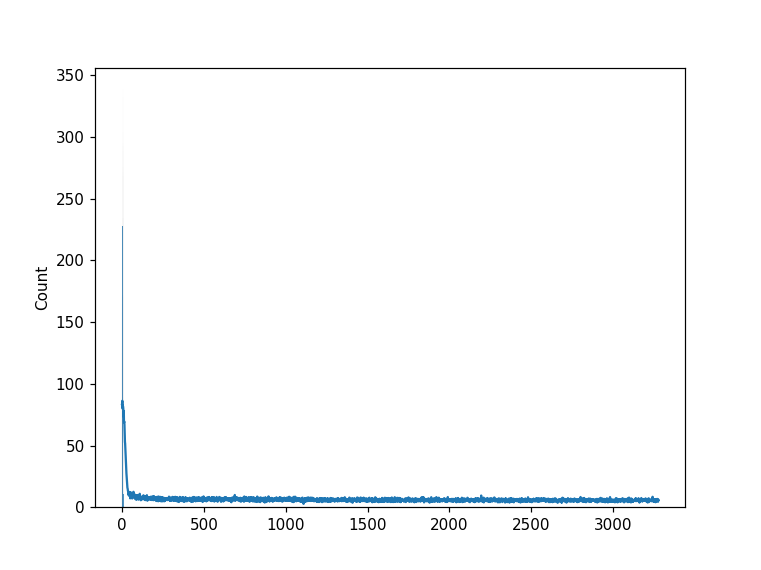

In [7]:
BATCH_SIZE=256
EPOCHS = 1

def SGD(model, data, idxs, neg_ratio=5):
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # learning rate
    idxs = get_pos_neg_samples(data, idxs, neg_ratio)
    data = torch.FloatTensor(data).cuda()
    l = []
    for epoch in range(EPOCHS):
        idxs = np.random.permutation(idxs)
        for i in tqdm(range(0, idxs.shape[0], BATCH_SIZE)):
            batch_idxs = idxs[i:i+BATCH_SIZE]
            row_idxs, col_idxs = batch_idxs[:,0], batch_idxs[:,1]
            rows = data[row_idxs,:]
            cols = data[:,col_idxs].T
        
            # Set gradients to zero
            optimizer.zero_grad()

            # Get the actual ratings
            rating = data[row_idxs, col_idxs]
            
            # Predict and calculate loss
            prediction = model(rows, cols)

            loss = loss_func(prediction, rating)

            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()
            l.append(loss)
        
        plt.plot(l[:-1])
        plt.show()

SGD(model, ratings, train_idxs)


In [8]:
def test(model, data, idxs, sample=5000):
    with torch.no_grad():
        pos = data[idxs[:,0], idxs[:,1]].nonzero()[0]
        data = torch.Tensor(data)
        samples = np.random.choice(len(pos), sample)
        row_idxs = idxs[samples,0]
        col_idxs = idxs[samples,1]
        rows = torch.FloatTensor(data[row_idxs,:]).cuda()
        cols = torch.FloatTensor(data[:,col_idxs]).T.cuda()
        mean = data[row_idxs,col_idxs].mean()
        print("Baseline score:", np.sqrt(((data[row_idxs,col_idxs] - mean)**2).sum() / len(row_idxs)))
        print("Model score:", np.sqrt(((data[row_idxs,col_idxs] - model(rows,cols).cpu()*10))**2).sum().cpu() / len(row_idxs))
        sns.histplot(np.array(model(rows, cols).cpu()))    
        plt.show()


test(model, ratings, validate_idxs)

Baseline score: tensor(2.2193)
Model score: tensor(39.9479)
